In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import speclite.filters

In [3]:
c = 3e18 # A / s
h = 6.626e-27 # erg s
k_B = 1.381e-16 # erg / K

In [4]:
def blackbody(lam, T):
    # From R&L 1.52 (extra factor of 4 * np.pi comes from integrating over solid angle)
    num = (8 * np.pi * h * c ** 2) / lam ** 5 
    den = np.exp(h * c / (lam * k_B * T)) - 1
    return(num / den) # multiply by (1e8) ** 2 if converting from A^-2 to cm^-2

def redshift(lam, sed, z):
    a = 1 / (1 + z)
    return(lam / a, sed * a)

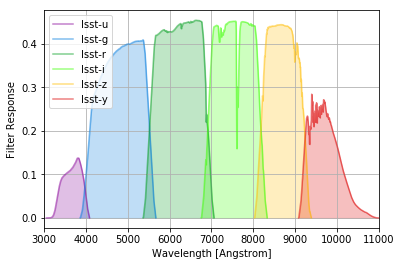

In [5]:
# LSST filters
lsst = speclite.filters.load_filters('lsst2016-*')
speclite.filters.plot_filters(lsst, wavelength_limits=(3000, 11000), legend_loc='upper left')

#### Blackbody spectrum

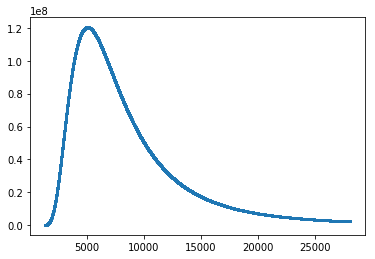

In [6]:
T = 8000
lam = np.arange(1000, 20000, 0.1)
sed = blackbody(lam, T) * 1e16

# z = 0.4
wlen, flux = redshift(lam, sed, 0.4)

plt.scatter(wlen, flux, s=1)
plt.show()

In [7]:
def calculate_colors(wlen_min, wlen_max, step, z, T):
    
    z = np.asarray(z)
    T = np.asarray(T)
    
    nz = len(z)
    nt = len(T)
    
    r_i = np.empty((nt, nz))
    i_z = np.copy(r_i)
    
    for i, tt in enumerate(T):
        
        lam_rest = np.arange(wlen_min, wlen_max, step)
        sed_rest = blackbody(lam=lam_rest, T=tt)
        
        for j, zz in enumerate(z):
            
            lam, sed = redshift(lam=lam_rest, sed=sed_rest, z=zz)
            
            # need to catch error when sed is redshifted and wlen range doesn't cover filter response range
            FilterConvR = speclite.filters.FilterConvolution(lsst[2], lam) # samples the filter response at the sed wlen?
            FilterConvI = speclite.filters.FilterConvolution(lsst[3], lam)
            FilterConvZ = speclite.filters.FilterConvolution(lsst[4], lam)

            rconv = FilterConvR.__call__(sed)
            iconv = FilterConvI.__call__(sed)
            zconv = FilterConvZ.__call__(sed)
            
            r_i[i,j] = -2.5 * np.log10(rconv / iconv)
            i_z[i,j] = -2.5 * np.log10(iconv / zconv)
            
    return(r_i, i_z)

In [8]:
redshifts = np.arange(0, 3.6, 0.2)
temperatures = [4000, 5000, 6000, 7000, 8000, 9000, 10000]

wlen_min = 1000
wlen_max = 20000
step = 0.1

r_i, i_z = calculate_colors(wlen_min, wlen_max, step, redshifts, temperatures)

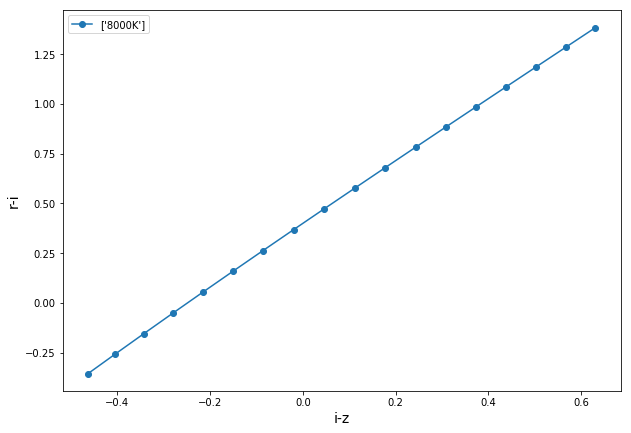

In [9]:
plt.figure(figsize=(10,7))
label = ['8000K']
plt.plot(i_z[4], r_i[4], 'o-', label=label)
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.legend(loc=2)
plt.show()

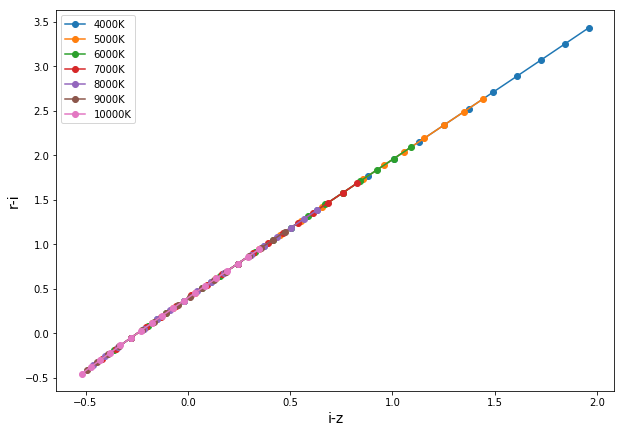

In [10]:
plt.figure(figsize=(10,7))
labels = ['4000K', '5000K', '6000K', '7000K' ,'8000K', '9000K', '10000K']
for k in range(len(temperatures)):
    plt.plot(i_z[k], r_i[k], 'o-', label=labels[k])
plt.xlabel('i-z', fontsize=14)
plt.ylabel('r-i', fontsize=14)
plt.legend(loc=2)
plt.show()